## Real

In [3]:
import json
import numpy as np
import pathlib
import pandas as pd

for overhead in [0.01, 0.1, 0.15, 0.2]:
    # for overhead in [0.01, 0.1, 0.15, 0.2]:
    # EXP_PATH = '../exp'
    # EXP_PATH = '../exp/gamma_random_start'
    # EXP_PATH = '../exp/gamma_5_0.1_alpha_larger_1'
    # EXP_PATH = '../exp/exp_0.02'
    # EXP_PATH = '../exp/exp_real_mean'
    # EXP_PATH = '../exp/exp_real_preemption_ratio_0.6'
    # EXP_PATH = f'../exp/exp_real_mean_overhead={overhead}'
    EXP_PATH = f'../exp-new-sliced/real_overhead={overhead}'
    # EXP_PATH = f'../exp-new-sliced/exp-gap_600-real_mean_over=0.1'
    # EXP_PATH = f'../exp-new-sliced/exp-gap_60-real_mean_over=0.1'
    # EXP_PATH = f'../exp/exp_real_mean_overhead={overhead}'



    TRACE_TYPE = 'trace-us-west-2a_v100_1'
    # TRACE_TYPE = 'trace-us-west-2a_v100_8'
    # TRACE_TYPE = 'trace-us-west-2a_k80_1'
    # TRACE_TYPE = 'trace-random_start_time'
    # TRACE_TYPE = 'trace-gap_600-alive_5.0_0.1-wait_5.0_0.1_random'
    # TRACE_TYPE = 'trace-gap_600-alive_0.02-wait_0.02_random'
    # TRACE_TYPE = 'trace-exp_gap_600-alive_0.04082965866405357-wait_0.1559405943681992_random'
    # TRACE_TYPE = 'trace-gap_600-preemption_rate_0.6_random'
    # TRACE_TYPE = 'trace-exp_gap_600-real_mean'
    # TRACE_TYPE = 'trace-gap_60-real_mean_random'


    def get_demand_ratio(history):
        demand_ratio = []
        for h in history:
            r = np.array([item['RequestType'] - 1 for item in h[1:]])
            total_job_time = sum(r > 0)
            total_demand_time = sum(r == 2)
            demand_ratio.append(total_demand_time / total_job_time)
        return np.mean(demand_ratio)

    def get_switches(history):
        switches = []
        for h in history:
            r = np.array([item['RequestType'] - 1 for item in h])
            switches.append(sum((r[:-1] != r[1:]) & (r[1:] > 0)))
        return np.array(switches)

    result_df = pd.DataFrame(columns=['algorithm', 'slice interval', 'use_avg', 'max slice slacks', 'max total slacks', 'demand ratio', 'cost', 'switches'])
    with open(f'{EXP_PATH}/on_demand-{TRACE_TYPE}-ddl=1000.0-dur=48.0-over={overhead}', 'r') as f:
        on_demand = json.load(f)
        on_demand_cost = on_demand['costs']
        result_df = result_df.append({
            'algorithm': 'on_demand',
            'slice interval': 52,
            'use_avg': False,
            'demand ratio': get_demand_ratio(on_demand['history']),
            'switches': get_switches(on_demand['history']),
            'cost': np.array(on_demand_cost)
        }, ignore_index=True)

    with open(f'{EXP_PATH}/strawman-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
        greedy = json.load(f)
        greedy_cost = greedy['costs']
        result_df = result_df.append(
            {
                'algorithm': 'greedy',
                'slice interval': 52,
                'use_avg': False,
                'demand ratio': get_demand_ratio(greedy['history']),
                'switches': get_switches(greedy['history']),
                'cost': np.array(greedy_cost)
            },
            ignore_index=True)

    for i in [1, 2, 4, 8, 16]:
        for avg in ['', '_avg']:
            try:
                with open(f'{EXP_PATH}/time_sliced{avg}_{i}.0h-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
                    pair = json.load(f)
                    pair_cost = pair['costs']
                    result_df = result_df.append(
                        {
                            'algorithm': 'time_sliced',
                            'slice interval': i,
                            'use_avg': bool(avg),
                            'demand ratio': get_demand_ratio(pair['history']),
                            'switches': get_switches(pair['history']),
                            'cost': np.array(pair_cost)
                        },
                        ignore_index=True)
            except FileNotFoundError:
                pass

            try:
                with open(f'{EXP_PATH}/loose_time_sliced{avg}_{i}.0h-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
                    pair = json.load(f)
                    pair_cost = pair['costs']
                    result_df = result_df.append(
                        {
                            'algorithm': 'loose_time_sliced',
                            'slice interval': i,
                            'use_avg': bool(avg),
                            'demand ratio': get_demand_ratio(pair['history']),
                            'switches': get_switches(pair['history']),
                            'cost': np.array(pair_cost)
                        },
                        ignore_index=True)
            except FileNotFoundError:
                pass

            for ss in [1, 2, 4, 6, 8]:
                try:
                    with open(f'{EXP_PATH}/loose_time_sliced{avg}_{i}.0h_ss_{ss}-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
                        pair = json.load(f)
                        pair_cost = pair['costs']
                        result_df = result_df.append(
                            {
                                'algorithm': 'loose_time_sliced',
                                'slice interval': i,
                                'use_avg': bool(avg),
                                'max slice slacks': ss,
                                'max total slacks': None,
                                'demand ratio': get_demand_ratio(pair['history']),
                                'switches': get_switches(pair['history']),
                                'cost': np.array(pair_cost)
                            },
                            ignore_index=True)
                except FileNotFoundError:
                    pass
            for ts in [8, 12, 16, 20, 24]:
                try:
                    with open(f'{EXP_PATH}/loose_time_sliced{avg}_{i}.0h_ts_{ts}-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
                        pair = json.load(f)
                        pair_cost = pair['costs']
                        result_df = result_df.append(
                            {
                                'algorithm': 'loose_time_sliced',
                                'slice interval': i,
                                'use_avg': bool(avg),
                                'max slice slacks': None,
                                'max total slacks': ts,
                                'demand ratio': get_demand_ratio(pair['history']),
                                'switches': get_switches(pair['history']),
                                'cost': np.array(pair_cost)
                            },
                            ignore_index=True)
                except FileNotFoundError:
                    pass
            for group_i in [1, 2, 4, 8, 16]:
                for group_j in [1, 2, 4, 8, 16]:
                    try:
                        with open(f'{EXP_PATH}/group_time_sliced{avg}_{group_i}_{group_j}h-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
                            pair = json.load(f)
                            pair_cost = pair['costs']
                            result_df = result_df.append(
                                {
                                    'algorithm': 'group_time_sliced',
                                    'slice interval': (group_i, group_j),
                                    'use_avg': bool(avg),
                                    'demand ratio': get_demand_ratio(pair['history']),
                                    'switches': get_switches(pair['history']),
                                    'cost': np.array(pair_cost)
                                },
                                ignore_index=True)
                    except FileNotFoundError:
                        pass

    # for avg in ['', '_avg']:
    #     with open(f'{EXP_PATH}/random_time_sliced_avg_2.0_4.0_8.0-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
    #         rand_slice = json.load(f)['costs']
    #         results[f'rand_sliced_2_4_8{avg}'] = np.array(rand_slice)

    try:
        with open(f'{EXP_PATH}/ideal_ilp_overhead-{TRACE_TYPE}-ddl=52.0-dur=48.0-over={overhead}', 'r') as f:
            ideal = json.load(f)
            ideal_cost = ideal['costs']
            result_df = result_df.append(
                {
                    'algorithm': 'ideal_ilp',
                    'slice interval': 52,
                    'use_avg': False,
                    'demand ratio': get_demand_ratio(ideal['history']),
                    'switches': get_switches(ideal['history']),
                    'cost': np.array(ideal_cost)
                },
                ignore_index=True)
    except FileNotFoundError:
        pass

    with open(f'{EXP_PATH}/only_spot-{TRACE_TYPE}-ddl=1000.0-dur=48.0-over={overhead}', 'r') as f:
        r = json.load(f)
        spot = r['costs']
        # spot_time = [t * 10 / 60 / 52 for t in r['ticks']]
        result_df = result_df.append(
            {
                'algorithm': 'only_spot',
                'slice interval': 52,
                'use_avg': False,
                'demand ratio': get_demand_ratio(r['history']),
                'switches': get_switches(r['history']),
                'cost': np.array(spot)
            },
            ignore_index=True)

    on_demand_cost = result_df[result_df['algorithm'] ==
                            'on_demand']['cost'].values[0]
    result_df['cost'] = result_df['cost'].apply(lambda x: x / on_demand_cost)
    funcs = {
        'mean': np.mean,
        'p90': lambda x: np.percentile(x, 90),
        'p95': lambda x: np.percentile(x, 95),
        'std': np.std
    }

    for name, func in funcs.items():
        result_df[name] = result_df['cost'].apply(func)


    results_path = pathlib.Path(EXP_PATH).name + '.csv'
    results_path = pathlib.Path('../results-new-sliced') / results_path
    results_path.parent.mkdir(parents=True, exist_ok=True)

    result_df.to_json(results_path.with_suffix('.json'), indent=2)
    result_df_without_cost = result_df.drop(columns=['cost', 'switches'])
    result_df_without_cost.to_csv(results_path.with_suffix('.csv'), sep='\t', index=False)

In [3]:
%matplotlib inline
from collections import defaultdict
import json
from matplotlib import pyplot as plt
import seaborn as sns
from sky_spot import env as env_lib

plt.rc('font', size=16)

def get_color(strategy):
    if strategy == 'on_demand':
        return 'black'
    if strategy == 'greedy':
        return 'green'
    if 'time_sliced' in strategy:
        return 'orange'
    if strategy == 'spot':
        return 'gray'
    if strategy == 'ideal':
        return 'pink'


def plot_worst(strategies=['strawman'], ratio=0.01):
    strategy_histories = {}
    for strategy in strategies:
        with open(f'{EXP_PATH}/{strategy}-{TRACE_TYPE}-ddl=52.0-dur=48.0-over=0.1', 'r') as f:
            strategy_histories[strategy] = json.load(f)

    first_strategy_history = strategy_histories[strategies[0]]
    cost_idx = zip(first_strategy_history['costs'], list(range(len(first_strategy_history['costs']))))
    cost_idx = sorted(cost_idx, key=lambda x: x[0])
    percentile_idx = [i[1] for i in cost_idx[-int(len(cost_idx) * ratio):]]
    print(percentile_idx)

    envs = env_lib.TraceEnv.create_env('../data/two_exp/gap_600-preemption_rate_0.2/exp_gap_600-preemption_rate_0.2_random', env_start_hours=0)

    costs = defaultdict(list)
    for i in range(len(percentile_idx)):
        idx = percentile_idx[-i]
        for strategy, history in strategy_histories.items():
            strategy_name = strategy.replace('pair_amortize', 'time_sliced').replace('strawman', 'greedy')
            costs[strategy_name].append(history['costs'][idx] / strategy_histories['strawman']['costs'][idx])

    for strategy, cost in costs.items():
        print(strategy, np.mean(cost), np.std(cost))
        sns.lineplot(cost, label=strategy, color=get_color(strategy))
    
        

    total_figures = min(len(percentile_idx), 10)
    fig, axes = plt.subplots(nrows=total_figures//2, ncols=2, figsize=(20, 10))
    for i in range(total_figures):
        idx = percentile_idx[-i]
        sns.lineplot([1 - p for p in envs[idx].trace[:len(first_strategy_history['history'][idx])]], drawstyle='steps-post', ax=axes[i//2][i%2], label='spot', color=get_color('spot'))
        for strategy, history in strategy_histories.items():
            request_types = [h['RequestType'] - 1 for h in history['history'][idx][1:]]
            strategy_name = strategy.replace('pair_amortize', 'time_sliced').replace('strawman', 'greedy')
            sns.lineplot(request_types, drawstyle='steps-post', linestyle='--', ax=axes[i//2][i%2], label=strategy_name, color=get_color(strategy_name))
        axes[i//2][i%2].set_yticks([0, 1, 2])
        axes[i//2][i%2].set_yticklabels(['NONE', 'SPOT', 'ON_DEMAND'])
        axes[i//2][i%2].get_legend().remove()
    handles, labels = axes[i//2][i%2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', ncol=len(labels), bbox_to_anchor=(1, -0.05), bbox_transform=fig.transFigure)
    fig.tight_layout(h_pad=1.5)
    plt.show()

[583, 717, 869, 877, 438, 704, 310, 390, 758, 815, 10, 86, 262, 326, 362, 381, 403, 549, 684, 703, 802, 834, 851, 83, 645, 973, 95, 167, 317, 345, 361, 395, 519, 938, 302, 12, 32, 38, 45, 91, 94, 96, 100, 121, 127, 135, 154, 161, 177, 225, 234, 242, 294, 342, 346, 380, 388, 391, 445, 473, 475, 479, 500, 514, 521, 544, 662, 677, 680, 690, 692, 723, 759, 760, 773, 780, 783, 790, 864, 880, 885, 920, 928, 996, 5, 36, 84, 88, 185, 293, 318, 525, 588, 615, 803, 841, 861, 905, 925, 968]
greedy 1.0 0.0
time_sliced_4.0h 0.6500597620332152 0.13382521598176922


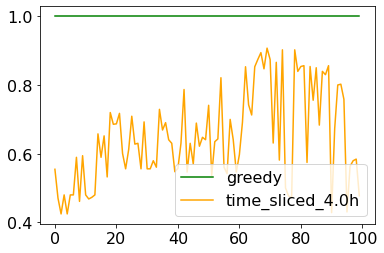

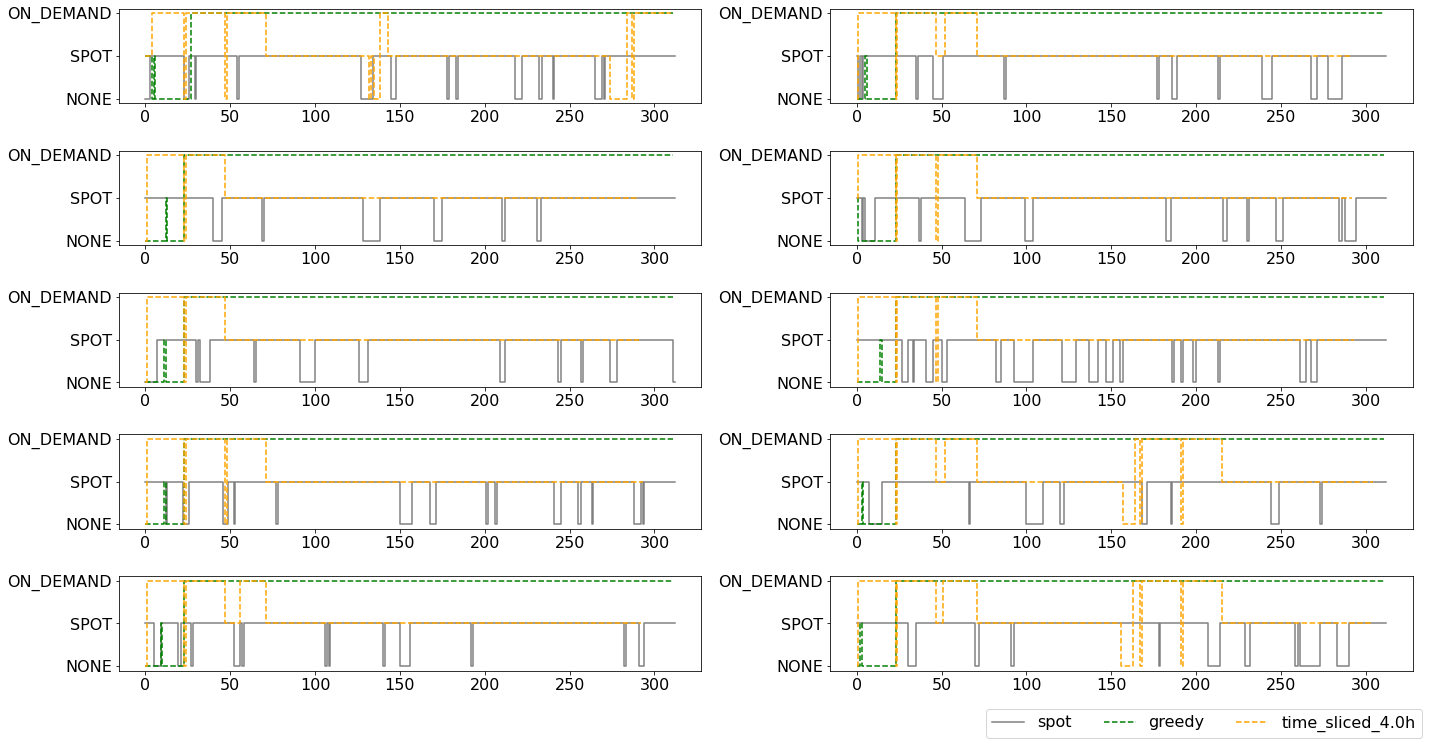

[818, 766, 112, 274, 699, 793, 526, 713, 49, 58, 569, 913, 386, 371, 470, 532, 141, 154, 74, 335, 276, 251, 262, 228, 781, 184, 376, 547, 954, 357, 341, 844, 708, 326, 834, 423, 450, 635, 190, 976, 812, 700, 519, 381, 253, 77, 649, 745, 549, 802, 174, 819, 748, 951, 249, 86, 703, 12, 45, 850, 193, 629, 969, 578, 643, 350, 19, 734, 558, 853, 197, 224, 155, 847, 936, 317, 126, 221, 53, 751, 361, 842, 302, 823, 882, 252, 686, 722, 226, 776, 571, 740, 938, 851, 95, 533, 737, 395, 752, 434]
time_sliced_4.0h 0.956488621720977 0.1214977339149609
greedy 1.0 0.0


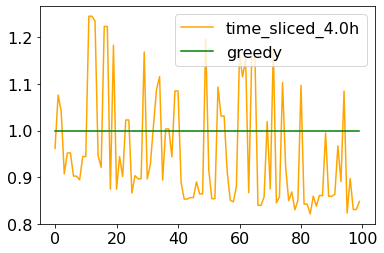

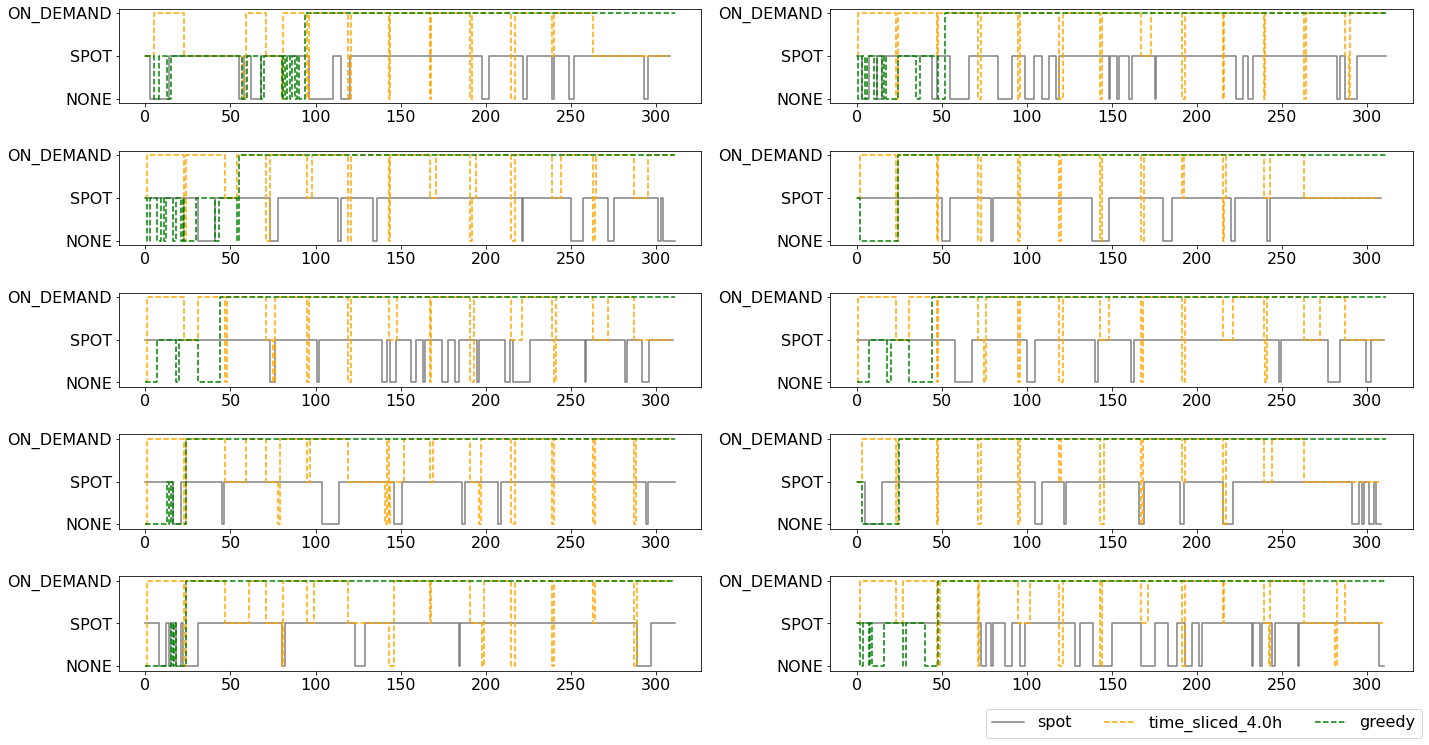

In [4]:
plot_worst(['strawman', 'time_sliced_4.0h'], ratio=0.1)
plot_worst(['time_sliced_4.0h', 'strawman'], ratio=0.1)
# plot_worst('exp/pair_amortize_4.0h-trace-us-west-2a_v100_1-ddl=52.0-dur=48.0-over=0.1', ratio=0.01)
